In [1]:
# allows to import own functions
import sys, os, re
root_project = re.findall(r'(^\S*TFM_AGM)', os.getcwd())[0]
sys.path.append(root_project)

from src.utils.help_func import results_searchcv
from src.features.add_features import features_graph, features_pop

In [2]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import networkx as nx
import json
import datetime
import seaborn as sns
import csv
sns.set()
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split


from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.optimizers import Adam, Nadam
from tensorflow.keras import initializers

import os
import time

In [3]:
tf.test.gpu_device_name()

'/device:GPU:0'

In [4]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 11742832662490776417,
 name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 18000096519705797506
 physical_device_desc: "device: XLA_CPU device",
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 6258765344
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 5353157748540358242
 physical_device_desc: "device: 0, name: GeForce RTX 2060 SUPER, pci bus id: 0000:01:00.0, compute capability: 7.5",
 name: "/device:XLA_GPU:0"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 12973604210695976522
 physical_device_desc: "device: XLA_GPU device"]

In [5]:
df = pd.read_pickle(f'{root_project}/data/processed/sir_simulation_100k.pickle')

In [6]:
df = features_graph(df)
df = features_pop(df)
df

,initial_country,idx_country,R0,Tc,Tr,omega,infection_power,mortality_power,limit_deaths,n_closed,react_time,total_infected,total_death,total_recovered,betweenness,degree,closeness,country_pop
0,LBN,106,9.490802,2.214174,21.014286,0.069029,2.918571e+03,0.007146,72,6,23,7.509918e+09,519114130.0,7.520727e+09,0.001057,0.270270,0.460581,6848925.0
1,KIR,99,3.161672,6.111805,19.323523,0.012080,9.342214e+03,0.003708,872,2,2,5.277990e+09,63875904.0,5.290389e+09,0.000956,0.036036,0.391534,115847.0
2,MOZ,129,16.439975,1.263448,20.771054,0.046275,8.045407e+04,0.002847,192,0,22,5.556171e+09,257680389.0,5.569051e+09,0.000059,0.054054,0.382759,29495962.0
3,ERI,58,2.141326,1.149404,2.461249,0.014779,5.593643e+03,0.006883,511,9,28,4.726189e+09,69844201.0,4.726335e+09,0.000007,0.049550,0.368159,3213972.0
4,VCT,174,9.327237,1.192357,11.121400,0.058201,9.890000e+03,0.013340,958,18,20,3.816622e+09,222144686.0,3.817037e+09,0.000035,0.040541,0.312236,110210.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,CZE,49,4.732819,2.439926,11.547730,0.030647,2.119500e+03,0.006201,13,2,15,1.055616e+07,323427.0,1.055615e+07,0.001189,0.342342,0.485777,10625695.0
99996,KAZ,97,11.763182,1.447605,17.028439,0.278547,6.076714e+03,0.023638,76,15,29,1.827643e+07,5090723.0,1.827634e+07,0.000831,0.216216,0.449393,18276499.0
99997,ITA,93,10.734467,0.201486,2.162848,0.029374,4.316507e+06,0.028820,434,12,21,6.043128e+07,1775100.0,6.043126e+07,0.017998,0.707207,0.572165,60431283.0
99998,ARM,7,19.957722,0.655780,13.087873,0.078398,2.108246e+05,0.019523,788,3,14,2.951768e+06,231336.0,2.951688e+06,0.000054,0.117117,0.424474,2951776.0


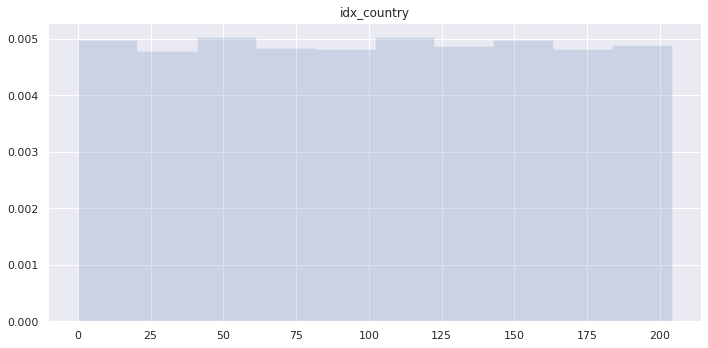

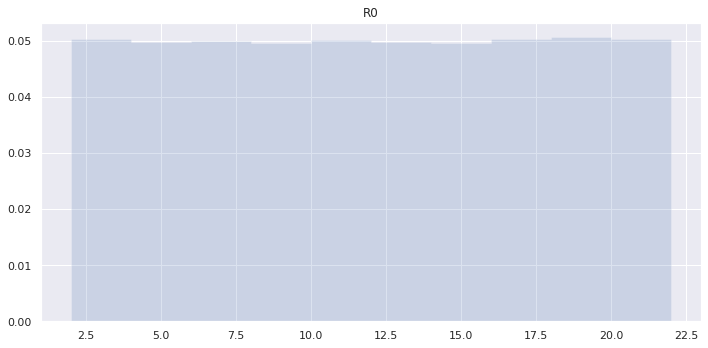

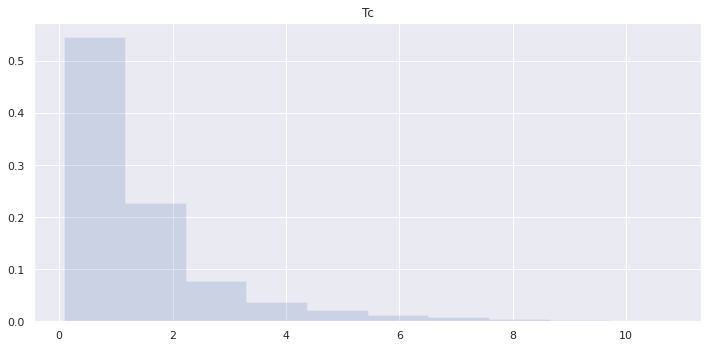

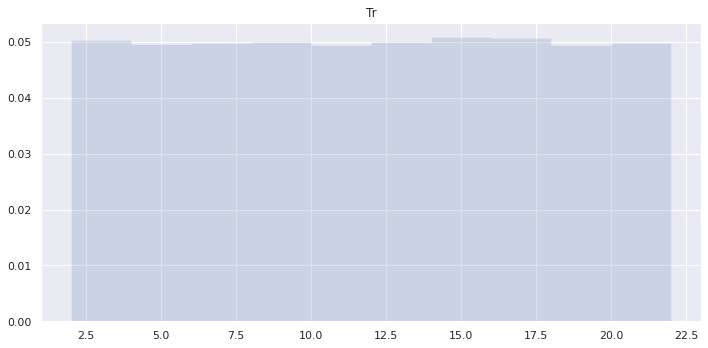

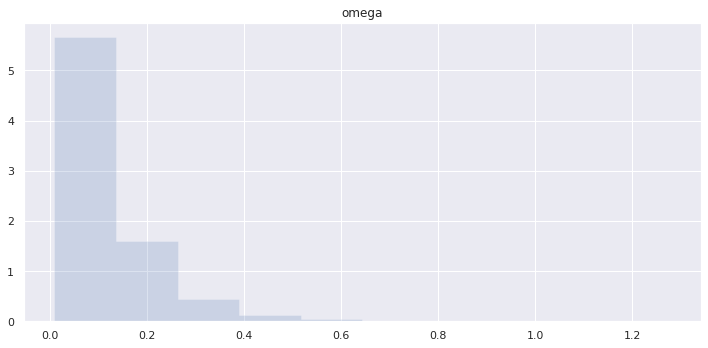

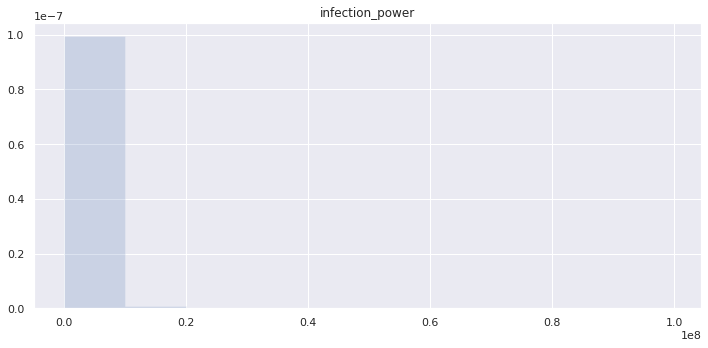

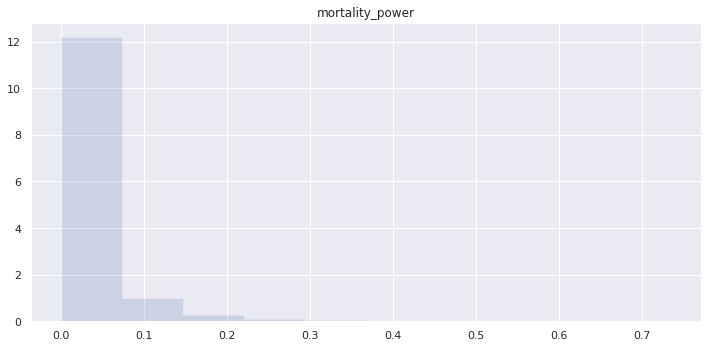

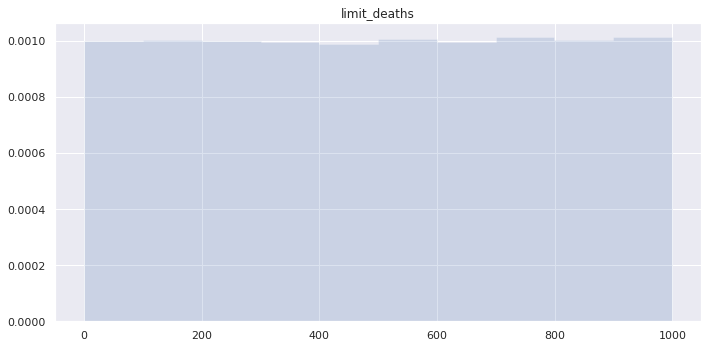

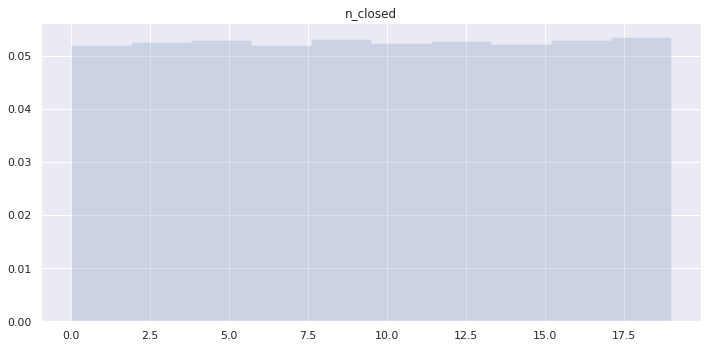

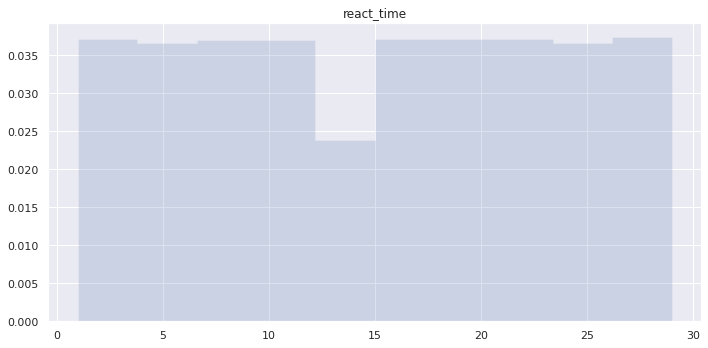

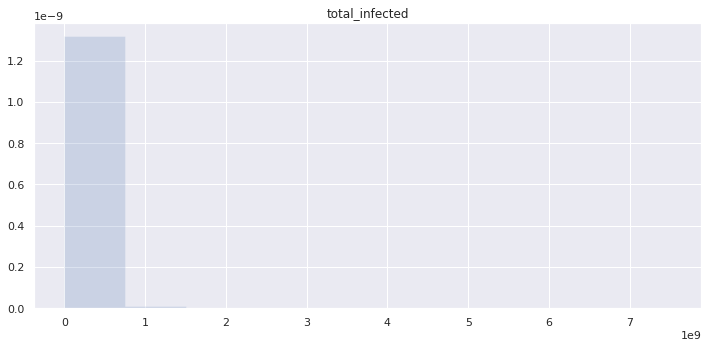

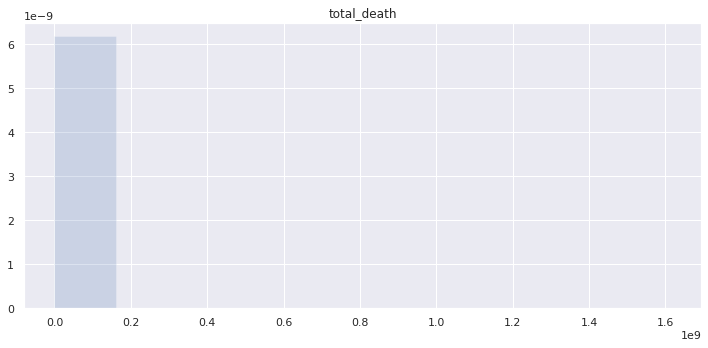

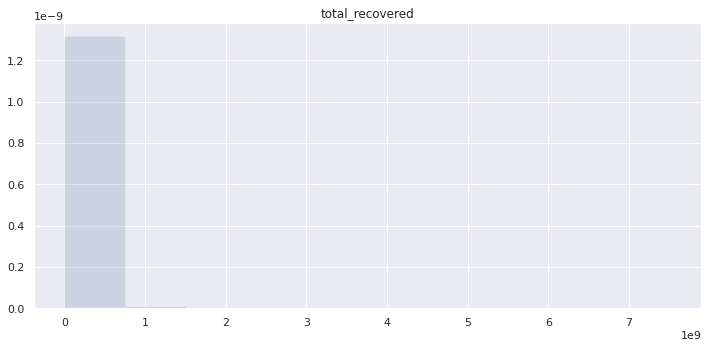

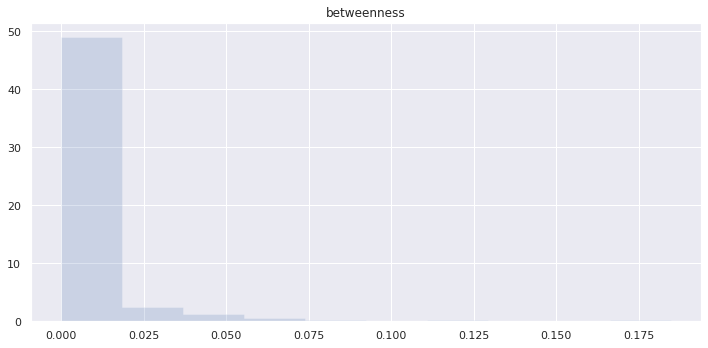

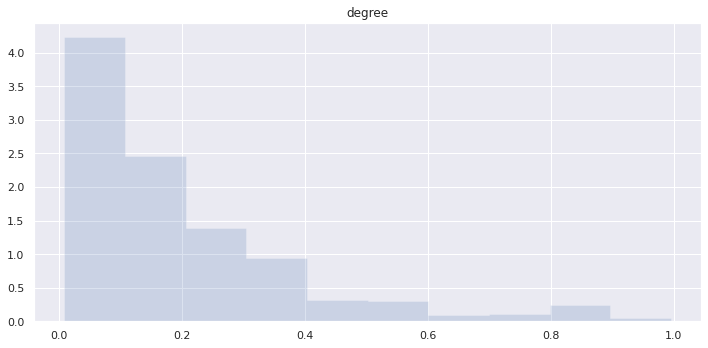

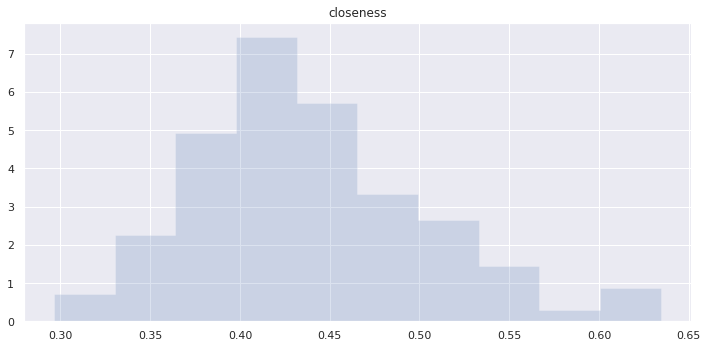

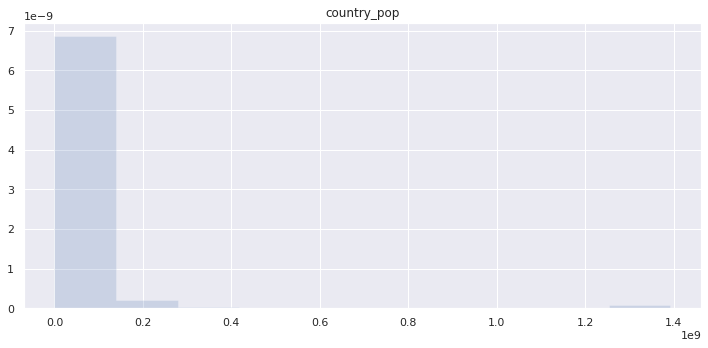

In [7]:
columns = df.describe().columns

for c in columns:
    fig, ax = plt.subplots(1, 1, figsize = (10,5))
    # df[c].plot(kind='hist', ax=ax, title=str(c))
    ax.hist(df[c], density=True, histtype='stepfilled', alpha=0.2)
    ax.set(title=str(c))
    plt.tight_layout()

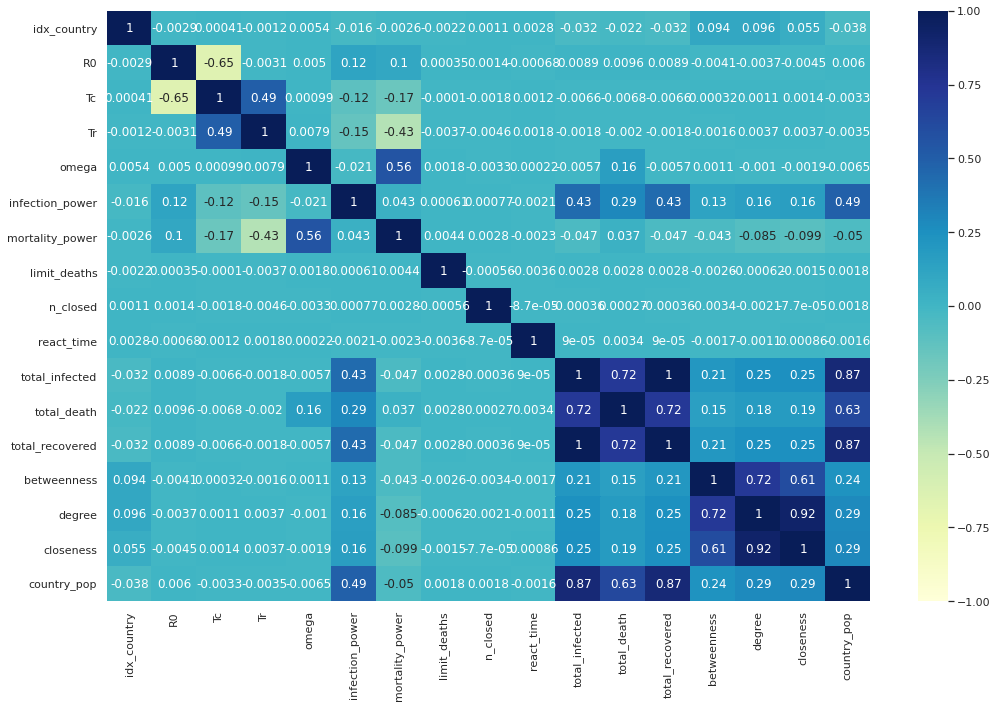

In [8]:
corr_matrix = df.corr()
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
sns.heatmap(corr_matrix, vmax=1, vmin=-1, annot=True, cmap="YlGnBu", ax=ax)
plt.tight_layout()

In [28]:
df_model = df[['Tr', 'infection_power', 'mortality_power', 'limit_deaths', 'n_closed', 'react_time',
               'total_death', 'betweenness', 'degree', 'closeness', 'country_pop']]

df_model = df[['Tr', 'R0', 'omega', 'limit_deaths', 'n_closed', 'react_time',
               'total_death', 'betweenness', 'degree', 'closeness', 'country_pop']]

# df_model = df_model.sample(30000) # par entrenar con menos muestras

size_data = int(len(df) / 1000)

df_model

,Tr,R0,omega,limit_deaths,n_closed,react_time,total_death,betweenness,degree,closeness,country_pop
0,21.014286,9.490802,0.069029,72,6,23,519114130.0,0.001057,0.270270,0.460581,6848925.0
1,19.323523,3.161672,0.012080,872,2,2,63875904.0,0.000956,0.036036,0.391534,115847.0
2,20.771054,16.439975,0.046275,192,0,22,257680389.0,0.000059,0.054054,0.382759,29495962.0
3,2.461249,2.141326,0.014779,511,9,28,69844201.0,0.000007,0.049550,0.368159,3213972.0
4,11.121400,9.327237,0.058201,958,18,20,222144686.0,0.000035,0.040541,0.312236,110210.0
...,...,...,...,...,...,...,...,...,...,...,...
99995,11.547730,4.732819,0.030647,13,2,15,323427.0,0.001189,0.342342,0.485777,10625695.0
99996,17.028439,11.763182,0.278547,76,15,29,5090723.0,0.000831,0.216216,0.449393,18276499.0
99997,2.162848,10.734467,0.029374,434,12,21,1775100.0,0.017998,0.707207,0.572165,60431283.0
99998,13.087873,19.957722,0.078398,788,3,14,231336.0,0.000054,0.117117,0.424474,2951776.0


In [29]:
X = df_model.drop('total_death', axis=1)
y = df_model['total_death']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training set: {X_train.shape}")
print(f"Test set: {X_test.shape}")

Training set: (80000, 10)
Test set: (20000, 10)


In [30]:
num_columns = X.columns


# num_columns = ['R0', 'Tr', 'omega', 'limit_deaths', 'n_closed', 'react_time', 'betweenness', 'degree', 'closeness',
#                'country_pop']

# cat_columns = ['initial_country']

# scaler = StandardScaler(with_mean=False, with_std=False)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train[num_columns].astype(np.float64))
X_test_scaled = scaler.transform(X_test[num_columns].astype(np.float64))

# oh = OneHotEncoder(handle_unknown='ignore')
# X_train_scaled = np.hstack((X_train_scaled, oh.fit_transform(X_train[cat_columns]).toarray()))
# X_test_scaled = np.hstack((X_test_scaled, oh.transform(X_test[cat_columns]).toarray()))

# scaler = StandardScaler()
# y_train = scaler.fit_transform(np.expand_dims(y_train.astype(np.float64),axis=1))
# y_test = scaler.transform(np.expand_dims(y_test.astype(np.float64),axis=1))



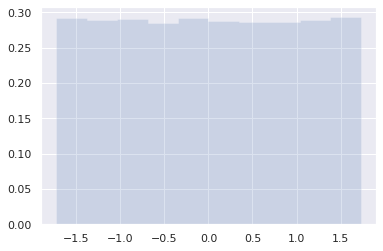

In [31]:
fig, ax = plt.subplots(1, 1)
ax.hist(X_train_scaled[:,1], density=True, histtype='stepfilled', alpha=0.2)
plt.show()

In [32]:
from keras import backend as K

def coeff_determination(y_true, y_pred):
    from keras import backend as K
    SS_res =  K.sum(K.square( y_true-y_pred ))
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) )
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

In [33]:
# import shutil
# shutil.rmtree('/content/drive/My Drive/TFM/archivos_colab/my_logs')

In [34]:
# root_logdir_tensorboard = '/content/drive/My Drive/TFM/archivos_colab/my_logs'
# root_logdir_checkpoints = '/content/drive/My Drive/TFM/archivos_colab/checkpoints'

root_logdir_tensorboard = f"{root_project}/models/my_logs"
root_logdir_checkpoints = f"{root_project}/models/checkpoints"

In [35]:
# dense_layers = [4, 5, 6]
# layer_sizes = [90,100,110]


dense_layers = [5]
layer_sizes = [80]

revision = 'rev9'

for dense_layer in dense_layers:
    for layer_size in layer_sizes:
        run_time = time.strftime("run_%d_%m_%Y-%H_%M_%S")
        NAME = f"{dense_layer}-layers-{layer_size}-nodes-{size_data}k-samples-{revision}-{run_time}"
        print(NAME)
        model = Sequential()
        inputs = Input(X_train_scaled.shape[1:])
        
        for l in range(dense_layer-1):
            model.add(Dense(layer_size, activation='selu', kernel_initializer='lecun_normal'))
        
        model.add(Dense(1))
        
        tensorboard_cb = keras.callbacks.TensorBoard(f"{root_logdir_tensorboard}/{NAME}")
        early_stopping_cb = keras.callbacks.EarlyStopping(patience=20, restore_best_weights=True)
        checkpoint_cb = keras.callbacks.ModelCheckpoint(filepath=f"{root_logdir_checkpoints}/{NAME}",
                                                       save_best_only=True, verbose=1)

        # model.compile(optimizer=Nadam(), loss='mean_squared_error', metrics=['mean_absolute_error'])
        model.compile(optimizer=Nadam(), loss='mean_squared_error',
                      metrics=['mean_absolute_error', coeff_determination])

        
        history = model.fit(X_train_scaled, y_train, epochs=500, verbose=0,
                            validation_data=(X_test_scaled, y_test),
                           callbacks=[tensorboard_cb, early_stopping_cb, checkpoint_cb])

        score_train = model.evaluate(X_train_scaled, y_train, verbose=0)
        score_test = model.evaluate(X_test_scaled, y_test, verbose=0)
        
        to_csv = [NAME, score_test[0], score_test[1], score_test[2]]
        
        with open('f{root_project}/models/result_models.csv', mode='w') as results_file:
            model_writer = csv.writer(results_file, delimiter=',')
            model_writer.writerow(to_csv)
        
        print('Train score:', score_train[0])
        print('Train MAE:', score_train[1])
        print('Train r-squared:', score_train[2])
        print('Test score:', score_test[0])
        print('Test MAE:', score_test[1])
        print('Test r-squared:', score_test[2])
        print('========')

5-layers-80-nodes-100k-samples-rev9-run_21_08_2020-12_02_31

Epoch 00001: val_loss improved from inf to 176177276780544.00000, saving model to /disks/hdd2T/Drive/TFM_AGM/models/checkpoints/5-layers-80-nodes-100k-samples-rev9-run_21_08_2020-12_02_31
INFO:tensorflow:Assets written to: /disks/hdd2T/Drive/TFM_AGM/models/checkpoints/5-layers-80-nodes-100k-samples-rev9-run_21_08_2020-12_02_31/assets

Epoch 00002: val_loss improved from 176177276780544.00000 to 161736824979456.00000, saving model to /disks/hdd2T/Drive/TFM_AGM/models/checkpoints/5-layers-80-nodes-100k-samples-rev9-run_21_08_2020-12_02_31
INFO:tensorflow:Assets written to: /disks/hdd2T/Drive/TFM_AGM/models/checkpoints/5-layers-80-nodes-100k-samples-rev9-run_21_08_2020-12_02_31/assets

Epoch 00003: val_loss improved from 161736824979456.00000 to 124323608133632.00000, saving model to /disks/hdd2T/Drive/TFM_AGM/models/checkpoints/5-layers-80-nodes-100k-samples-rev9-run_21_08_2020-12_02_31
INFO:tensorflow:Assets written to: /disks


Epoch 00034: val_loss did not improve from 28390260211712.00000

Epoch 00035: val_loss improved from 28390260211712.00000 to 28320613793792.00000, saving model to /disks/hdd2T/Drive/TFM_AGM/models/checkpoints/5-layers-80-nodes-100k-samples-rev9-run_21_08_2020-12_02_31
INFO:tensorflow:Assets written to: /disks/hdd2T/Drive/TFM_AGM/models/checkpoints/5-layers-80-nodes-100k-samples-rev9-run_21_08_2020-12_02_31/assets

Epoch 00036: val_loss improved from 28320613793792.00000 to 28092512862208.00000, saving model to /disks/hdd2T/Drive/TFM_AGM/models/checkpoints/5-layers-80-nodes-100k-samples-rev9-run_21_08_2020-12_02_31
INFO:tensorflow:Assets written to: /disks/hdd2T/Drive/TFM_AGM/models/checkpoints/5-layers-80-nodes-100k-samples-rev9-run_21_08_2020-12_02_31/assets

Epoch 00037: val_loss improved from 28092512862208.00000 to 27915108483072.00000, saving model to /disks/hdd2T/Drive/TFM_AGM/models/checkpoints/5-layers-80-nodes-100k-samples-rev9-run_21_08_2020-12_02_31
INFO:tensorflow:Assets w


Epoch 00085: val_loss did not improve from 23293182607360.00000

Epoch 00086: val_loss did not improve from 23293182607360.00000

Epoch 00087: val_loss did not improve from 23293182607360.00000

Epoch 00088: val_loss did not improve from 23293182607360.00000

Epoch 00089: val_loss did not improve from 23293182607360.00000

Epoch 00090: val_loss did not improve from 23293182607360.00000

Epoch 00091: val_loss improved from 23293182607360.00000 to 23231304040448.00000, saving model to /disks/hdd2T/Drive/TFM_AGM/models/checkpoints/5-layers-80-nodes-100k-samples-rev9-run_21_08_2020-12_02_31
INFO:tensorflow:Assets written to: /disks/hdd2T/Drive/TFM_AGM/models/checkpoints/5-layers-80-nodes-100k-samples-rev9-run_21_08_2020-12_02_31/assets

Epoch 00092: val_loss improved from 23231304040448.00000 to 23045481693184.00000, saving model to /disks/hdd2T/Drive/TFM_AGM/models/checkpoints/5-layers-80-nodes-100k-samples-rev9-run_21_08_2020-12_02_31
INFO:tensorflow:Assets written to: /disks/hdd2T/Driv


Epoch 00150: val_loss did not improve from 21121571225600.00000

Epoch 00151: val_loss did not improve from 21121571225600.00000

Epoch 00152: val_loss did not improve from 21121571225600.00000

Epoch 00153: val_loss did not improve from 21121571225600.00000

Epoch 00154: val_loss did not improve from 21121571225600.00000

Epoch 00155: val_loss did not improve from 21121571225600.00000

Epoch 00156: val_loss did not improve from 21121571225600.00000

Epoch 00157: val_loss did not improve from 21121571225600.00000

Epoch 00158: val_loss did not improve from 21121571225600.00000

Epoch 00159: val_loss did not improve from 21121571225600.00000

Epoch 00160: val_loss did not improve from 21121571225600.00000

Epoch 00161: val_loss improved from 21121571225600.00000 to 20855853678592.00000, saving model to /disks/hdd2T/Drive/TFM_AGM/models/checkpoints/5-layers-80-nodes-100k-samples-rev9-run_21_08_2020-12_02_31
INFO:tensorflow:Assets written to: /disks/hdd2T/Drive/TFM_AGM/models/checkpoints

FileNotFoundError: [Errno 2] No such file or directory: 'f{root_project}/models/result_models.csv'

In [ ]:
# model.save(f'/content/drive/My Drive/TFM/archivos_colab/models/{NAME}.h5')

In [ ]:
# model = load_model('/content/drive/My Drive/TFM/archivos_colab/checkpoints/5-layers-100-nodes-110k-samples-rev3-run_18_08_2020-14_45_53',
#                    custom_objects={'coeff_determination':coeff_determination})
# score_train = model.evaluate(X_train_scaled, y_train, verbose=0)
# score_test = model.evaluate(X_test_scaled, y_test, verbose=0)

# print('Train score:', score_train[0])
# print('Train MAE:', score_train[1])
# print('Train r-squared:', score_train[2])
# print('Test score:', score_test[0])
# print('Test MAE:', score_test[1])
# print('Test r-squared:', score_test[2])

In [36]:
X_err = X_test.copy()
X_err['predicted'] = model.predict(X_test_scaled)
X_err['real'] = y_test
X_err['error'] = X_err['real'] - X_err['predicted']
X_err['abs_error'] = np.abs(X_err['error'])
X_err

,Tr,R0,omega,limit_deaths,n_closed,react_time,betweenness,degree,closeness,country_pop,predicted,real,error,abs_error
75721,11.512972,2.002275,0.159685,990,11,9,0.008194,0.175676,0.463466,18729160.0,1.446005e+06,2399430.0,9.534251e+05,9.534251e+05
80184,7.099316,12.988851,0.022108,338,16,9,0.003207,0.306306,0.495536,4853506.0,5.313995e+05,107259.0,-4.241405e+05,4.241405e+05
19864,17.975615,21.025482,0.053718,794,2,25,0.009627,0.387387,0.526066,33699947.0,1.816852e+06,1810182.0,-6.669875e+03,6.669875e+03
76699,3.788375,4.840565,0.174796,173,1,15,0.000193,0.121622,0.411874,19751535.0,3.161945e+06,3447814.0,2.858688e+05,2.858688e+05
92991,9.060127,19.086416,0.154810,587,15,15,0.000000,0.009009,0.383420,55312.0,1.048571e+06,8521.0,-1.040050e+06,1.040050e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32595,19.122211,21.962952,0.057695,971,0,9,0.002871,0.054054,0.388792,106977.0,1.980534e+05,6099.0,-1.919544e+05,1.919544e+05
29313,11.765232,5.917744,0.079686,633,13,27,0.006499,0.121622,0.433594,96286.0,2.873419e+05,7607.0,-2.797349e+05,2.797349e+05
37862,4.013381,3.846607,0.028634,440,10,12,0.000579,0.072072,0.370618,8606316.0,6.950852e+05,243582.0,-4.515032e+05,4.515032e+05
53421,2.988766,2.713419,0.028438,38,9,7,0.001501,0.189189,0.460581,95540395.0,1.185244e+06,2554020.0,1.368776e+06,1.368776e+06


In [37]:
X.describe()

,Tr,R0,omega,limit_deaths,n_closed,react_time,betweenness,degree,closeness,country_pop
count,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,1.000000e+05
mean,12.001955,12.019170,0.109945,500.815290,9.527970,15.022590,0.006649,0.194115,0.439997,3.727047e+07
std,5.769646,5.785857,0.099989,288.703688,5.766858,8.377824,0.019031,0.189428,0.065787,1.414215e+08
min,2.000186,2.001378,0.010001,1.000000,0.000000,1.000000,0.000000,0.009009,0.296395,1.164600e+04
25%,7.000645,6.989443,0.038695,250.000000,5.000000,8.000000,0.000058,0.063063,0.392920,1.136191e+06
50%,12.028737,12.025635,0.079293,502.000000,10.000000,15.000000,0.000554,0.126126,0.427746,7.024216e+06
75%,16.979347,17.050237,0.148595,751.000000,15.000000,22.000000,0.003897,0.261261,0.478448,2.626237e+07
max,21.999318,21.999739,1.278734,999.000000,19.000000,29.000000,0.184702,0.995495,0.634286,1.392730e+09


In [38]:
X_err_sorted = X_err.sort_values(by='abs_error', ascending=False).iloc[:200]
X_err_sorted.describe()

,Tr,R0,omega,limit_deaths,n_closed,react_time,betweenness,degree,closeness,country_pop,predicted,real,error,abs_error
count,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,2.000000e+02,2.000000e+02,2.000000e+02,2.000000e+02,2.000000e+02
mean,12.782620,11.860524,0.343834,486.880000,9.415000,15.230000,0.021432,0.319820,0.490541,2.277272e+08,4.507145e+07,5.527653e+07,1.020508e+07,2.122523e+07
std,5.471373,6.095709,0.188678,296.369635,6.308069,8.887182,0.046493,0.225021,0.064169,3.953031e+08,9.719599e+07,1.046018e+08,4.140507e+07,3.696313e+07
min,2.030165,2.031302,0.010254,2.000000,0.000000,1.000000,0.000000,0.027027,0.356913,9.676200e+04,1.931993e+05,4.410580e+05,-3.898949e+07,8.749127e+06
25%,8.692291,6.406945,0.192618,233.000000,3.000000,7.750000,0.001221,0.163288,0.439387,2.546642e+07,8.366749e+06,1.509537e+07,-1.058662e+07,1.006207e+07
50%,13.233827,11.871618,0.350742,454.000000,10.000000,16.000000,0.005093,0.225225,0.484716,9.554040e+07,2.341727e+07,2.612943e+07,9.732082e+06,1.212039e+07
75%,17.345906,16.889796,0.479013,764.750000,15.000000,23.000000,0.017278,0.414414,0.529833,2.094693e+08,4.256445e+07,5.044862e+07,1.427105e+07,1.748035e+07
max,21.891166,21.847257,0.918575,998.000000,19.000000,29.000000,0.184702,0.864865,0.620112,1.392730e+09,9.477743e+08,9.903641e+08,3.119989e+08,3.119989e+08


Para ver donde estoy cometiendo los errores

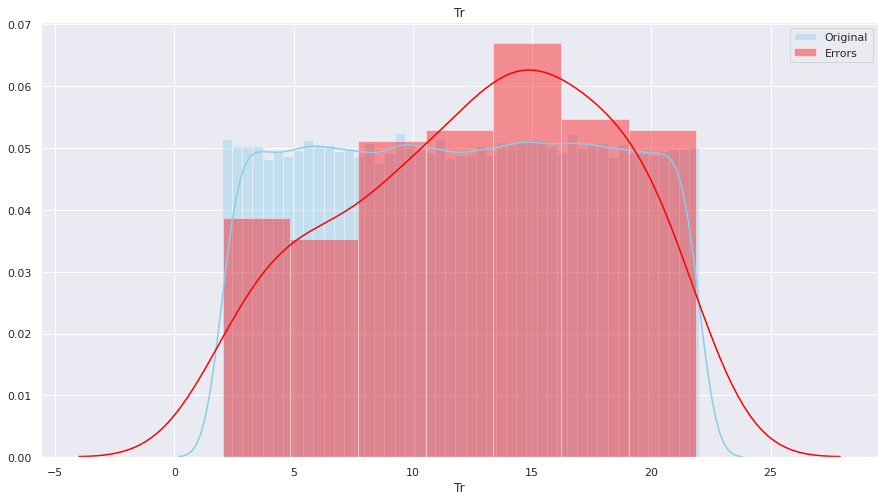

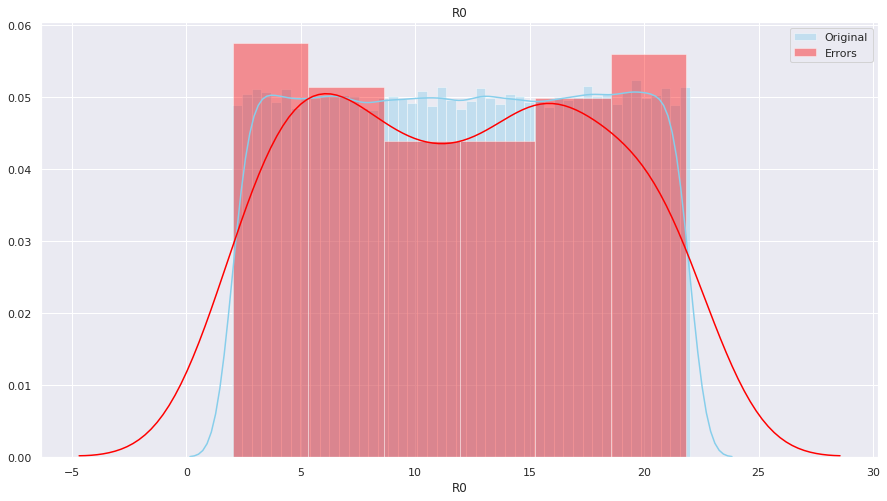

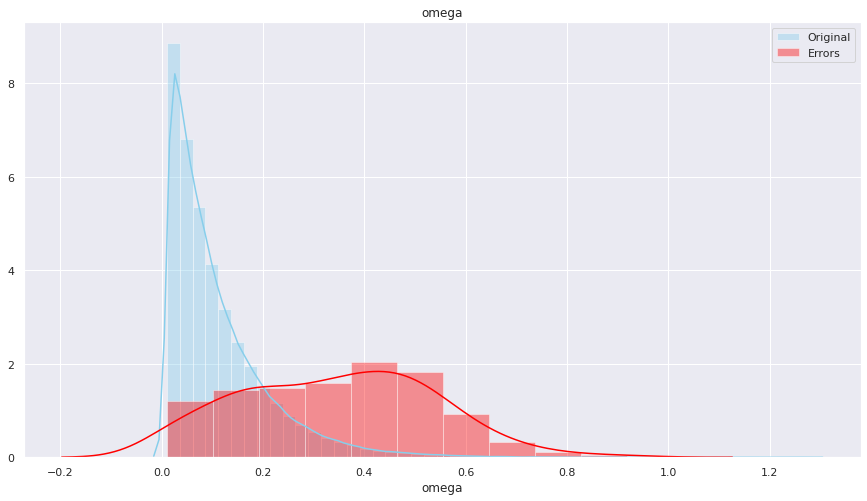

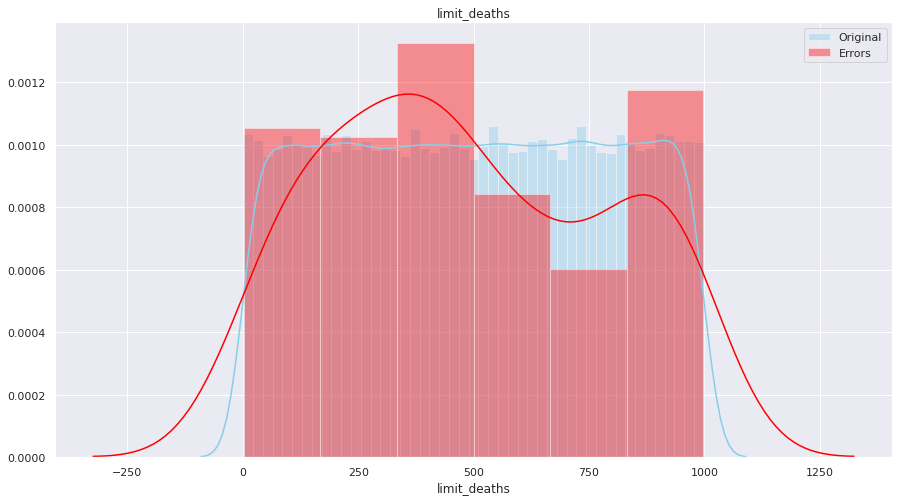

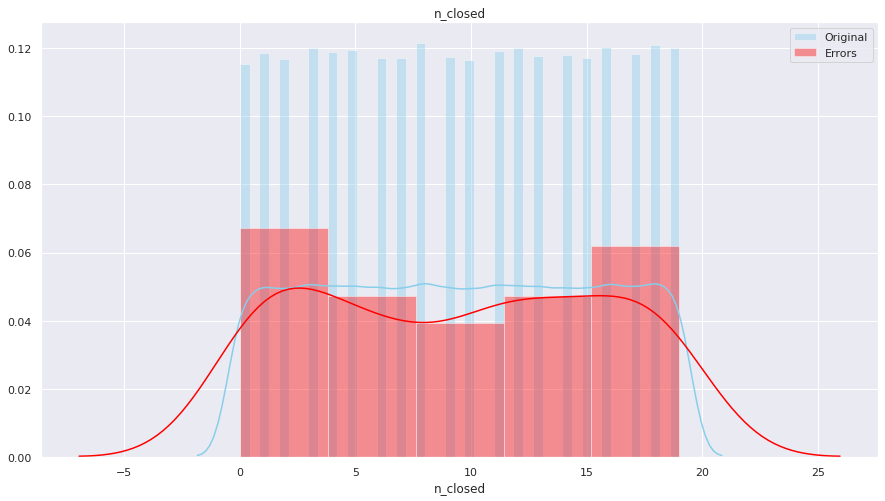

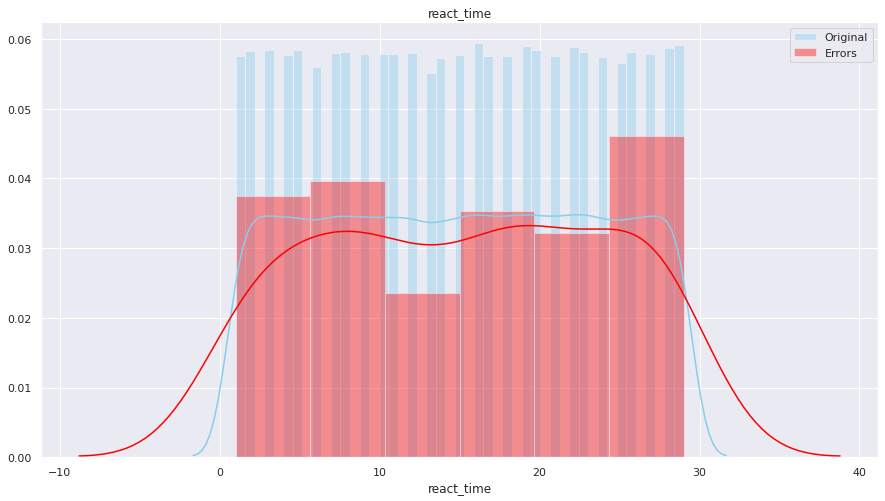

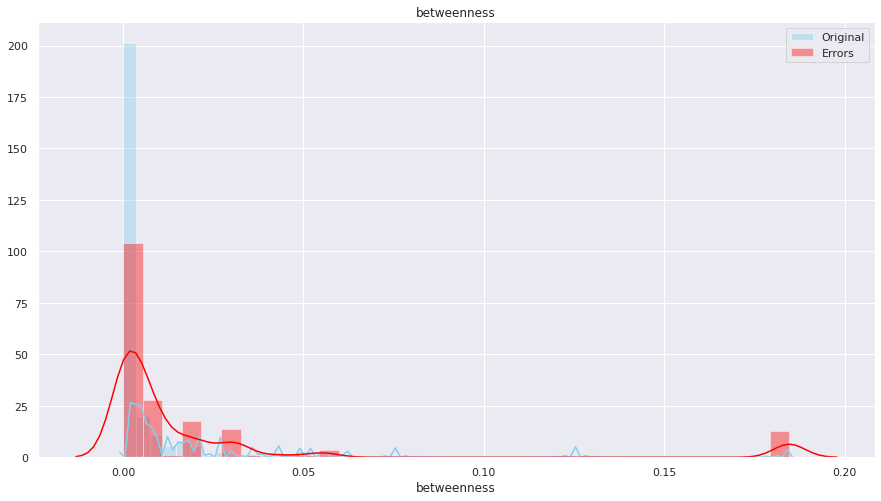

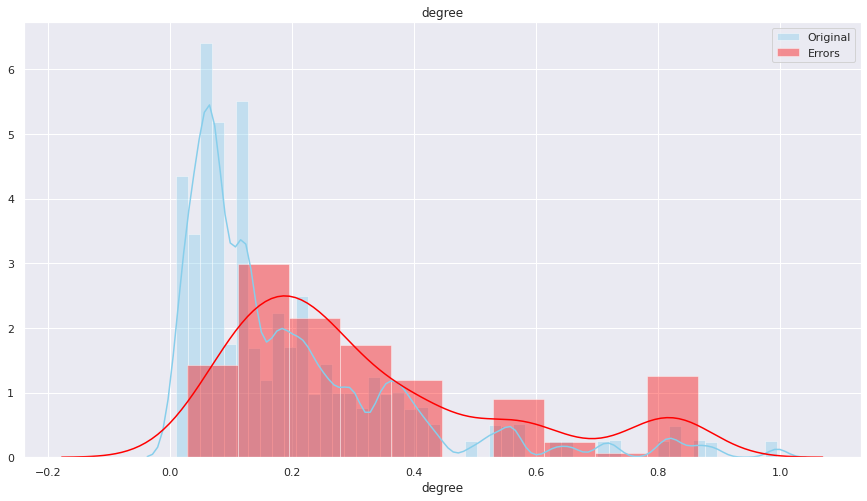

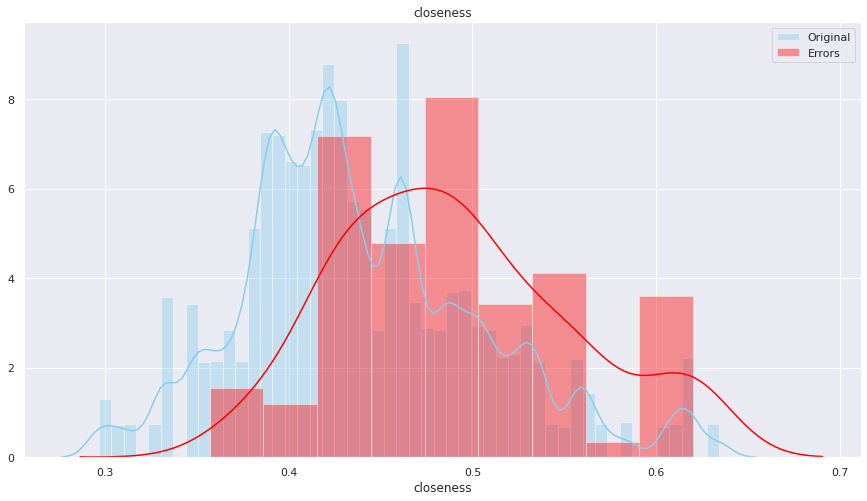

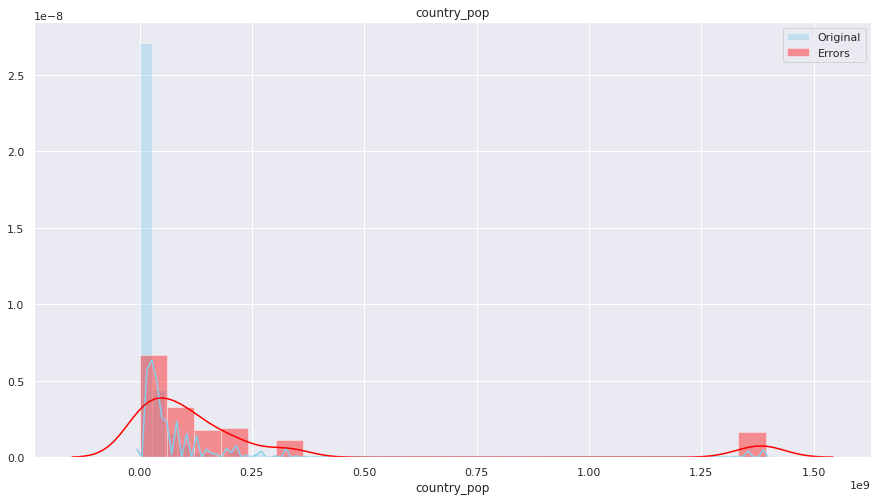

In [39]:
for column in X.columns:
  fig, ax = plt.subplots(1, 1, figsize = (15,8))
  sns.distplot(X[column], hist=True, color='skyblue', label='Original', ax=ax)
  sns.distplot(X_err_sorted[column], hist=True, color='red', label='Errors', ax=ax)
  ax.set(title=column)
  plt.legend()
  plt.show()

In [40]:
y_predicted = model.predict(X_test_scaled).flatten()
df_predicted = pd.DataFrame({'Actual': y_test, 'Predicted': y_predicted})

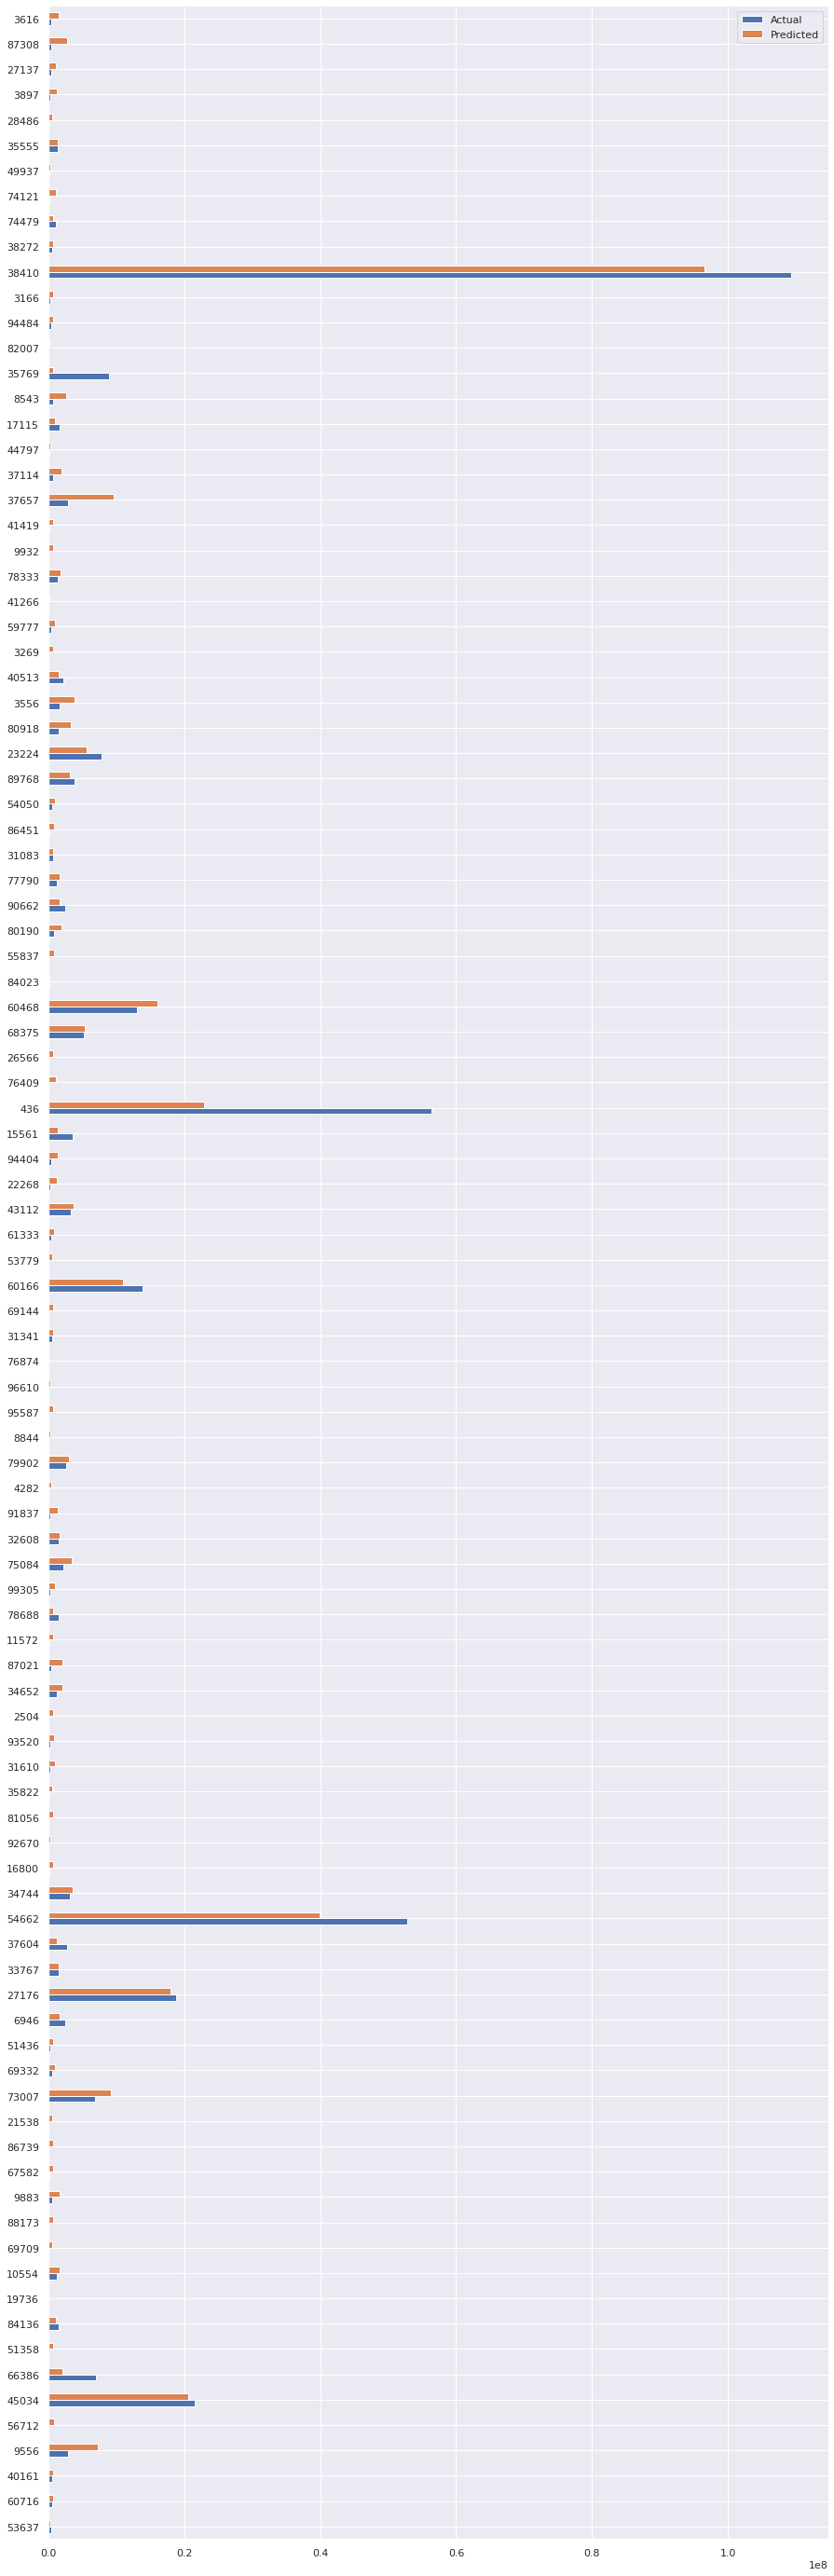

In [41]:
df_predicted.sample(100).plot(kind='barh',figsize=(15,50))
plt.show()